In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import warnings
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from datetime import date, datetime
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel('WTI_OilCurve.xlsx',skiprows=1)
data.set_index([1], inplace = True)
data = data[['PX LAST','PX LAST.1','PX LAST.2','PX LAST.3','PX LAST.4','PX LAST.5','PX LAST.6','PX LAST.7','PX LAST.8','PX LAST.9','PX LAST.10','PX LAST.11']]
data.columns = ['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12']
oil_monthend = data.resample('M').last()
oil_monthend.index.name = 'Date'
oil_monthend

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
Date,,,,,,,,,,,,
2000-01-31,27.64,26.72,25.97,25.32,24.71,24.17,23.71,23.27,22.87,22.49,22.14,21.81
2000-02-29,30.43,28.85,27.68,26.74,26.00,25.35,24.79,24.32,23.88,23.44,23.04,22.65
2000-03-31,26.90,26.38,26.04,25.76,25.48,25.19,24.90,24.60,24.28,23.97,23.68,23.39
2000-04-30,25.74,25.48,25.15,24.86,24.59,24.32,24.07,23.82,23.57,23.32,23.08,22.85
2000-05-31,29.01,28.42,27.89,27.40,26.92,26.47,26.06,25.69,25.32,24.95,24.58,24.21
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,73.25,73.06,72.89,72.70,72.51,72.31,72.09,71.84,71.51,71.16,70.82,70.45
2018-10-31,65.31,65.44,65.58,65.73,65.88,65.99,66.05,66.06,66.01,65.91,65.78,65.64
2018-11-30,50.93,51.09,51.23,51.36,51.50,51.60,51.66,51.71,51.76,51.80,51.84,51.89


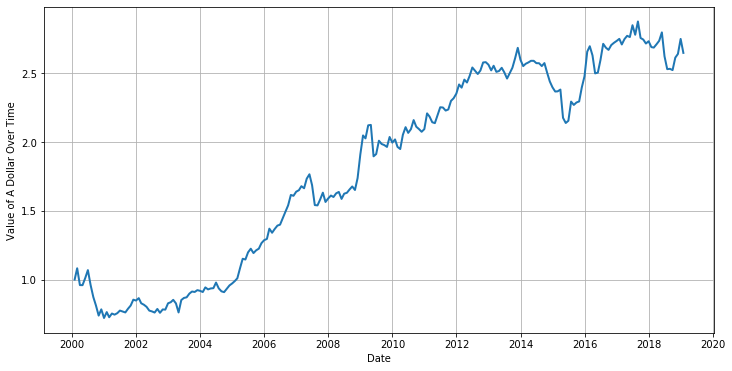

In [4]:
monthly_ret = []
for i in range(0, len(oil_monthend)-1):
    rolling_ret = []
    for j in range(11):
        rolling_ret.append(oil_monthend.iloc[i,j]/oil_monthend.iloc[i,j+1]-1)
    sortindex = np.argsort(rolling_ret)
    
    long = oil_monthend.iloc[i+1,sortindex[10]]/oil_monthend.iloc[i,sortindex[10]+1]-1
    short = oil_monthend.iloc[i+1,sortindex[0]]/oil_monthend.iloc[i,sortindex[0]+1]-1
    
    monthly_ret.append(long-short)

ret_multiplier = [1+i for i in monthly_ret]
dollarinvestment = np.cumprod(ret_multiplier)
dollarinvestment = np.insert(dollarinvestment, 0, 1)
plt.figure(figsize = (12,6))
plt.plot(oil_monthend.index, dollarinvestment, linewidth = 2)
plt.xlabel("Date")
plt.ylabel("Value of A Dollar Over Time")
plt.grid();

In [5]:
oil_future_portfolio_monthly_return = pd.DataFrame(monthly_ret, index=oil_monthend.index[1:],columns=['Monthly Return'])
oil_future_portfolio = oil_future_portfolio_monthly_return + 1
calendar_year_return = oil_future_portfolio.groupby(oil_future_portfolio.index.year).prod()
calendar_year_return -= 1
calendar_year_return

,Monthly Return
Date,
2000,-0.279277
2001,0.176147
2002,-0.023778
2003,0.109618
2004,0.058693
2005,0.323970
2006,0.273906
2007,-0.029794
2008,0.201022


In [6]:
Annualized_Ret = np.prod(ret_multiplier)**(12/len(ret_multiplier))-1
Annualized_Ret

0.052625728032006824

In [7]:
Annualized_Risk = np.std(monthly_ret)*np.sqrt(12)
Annualized_Risk

0.11807462918530853

In [8]:
Sharp_Ratio = Annualized_Ret/Annualized_Risk
Sharp_Ratio

0.4456988634655377

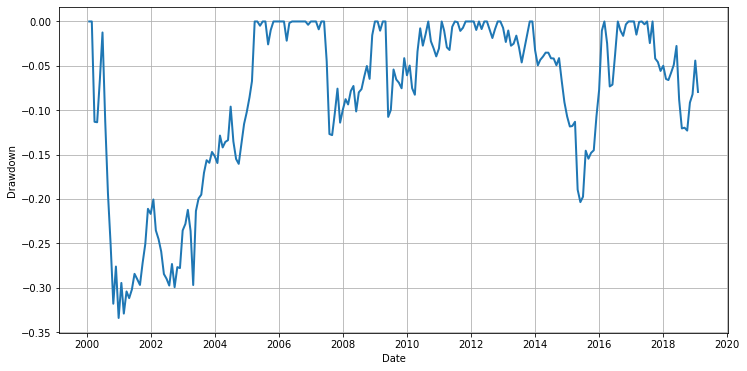

In [10]:
Drawdown = []
for i in range(len(dollarinvestment)):
    if dollarinvestment[i]/np.max(dollarinvestment[0:i+1])-1<0:
        Drawdown.append(dollarinvestment[i]/max(dollarinvestment[0:i+1])-1)
    else:
        Drawdown.append(0)
Drawdown = pd.DataFrame(Drawdown,index=oil_monthend.index,columns=['DrawDown'])

plt.figure(figsize = (12,6))
plt.plot(Drawdown.index,Drawdown,linewidth = 2)
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid();

In [12]:
MaximumDD = Drawdown.min()
MaxDDPeriod = Drawdown.loc[Drawdown['DrawDown']==MaximumDD['DrawDown']]
MaxDDPeriod

,DrawDown
Date,
2000-12-31,-0.334175


The maximum drawdown period starts from 2/29/2000 to 12/31/2000